In [2]:
import numpy as np
import os
import matplotlib.cm as cm
from scipy.special import expit as invlogit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
import scipy.stats as st
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

In [3]:
!python --version
print(pm.__version__)
print(az.__version__)
print(pd.__version__)
print(sns.__version__)

Python 3.8.5
3.11.0
0.11.1
1.2.2
0.11.0


In [4]:
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))

# Bayesian approach to testosterone effects estimation in risk-taking task
Estimation effects of testosterone application on decision making process (see. Effects of Testosterone Application on Loss Aversion and Risk Taking under Different Framing)

toDo: add task design (workflow) and short description

## Cumulative prospect theory

According  to prospect theory  (Fox, C. R. & Poldrack, R. A. Prospect Theory 149 Applications to Riskless Choice 151)  choice between two gambles is based on subjective value that represents  its desirability to decision maker. The value $V$ for simple prospect  that payoff $x$  with probability $p$  is given by  $V(x,p)=\omega(x)v(x)$ ,  where $w(x)$ measures impact effect of probability and $v(x)$ is subjective value of money.  The subjective value of payoff is  defined as power function from payoff 

$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\beta}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{c_{ind}}}{[p^{c_{ind}} + (1-p)^{c_{ind}}]^{1/{c_{ind}}}} $$
where $ind = +,\text{ for gain }, - \text{ loss }$

With accordance to prospect theory the decision maker should always choose an option with a larger subjective value. A 0 to 1 choice probability is usually described by exponential transform, which leads to logistic function choice function:

$$p(A,B)  = \frac{1}{1+e^{\phi(V(B)-V(A))}}$$
A - Game, B - sure, in our case

Later we will call difference $V(B)-V(A)$ as **Gap**



**Testosterone related parameters**


Testing how testosterone influences on decision making process
$$\theta = \log\frac{p}{1-p} = logit(p_i)  = (a_j+a_{cond}) + (\beta_j+\beta_{cond})*gap(A,B,\alpha,c)$$

## Data processing step


toDo: add data description here

Basic preprocessing steps

### Data from risk-taking task

In [13]:
df = pd.read_csv('Framing.csv',sep = ';')
m_df = pd.melt(df, id_vars='ID', value_vars=list(df.columns[1:]), value_name='Strategy')
m_df['Test'] = 1
m_df.loc[m_df['variable'].str.contains('P'),'Test'] = 0
m_df['Win'] = 1
m_df.loc[m_df['variable'].str.contains('_L'),'Win'] = 0
m_df['P'] = m_df.apply(lambda row: float(row.variable[-3:]), axis=1)
m_df.drop("variable", axis=1, inplace = True)
m_df.Strategy = m_df.Strategy - 1
win_money = {0.9: {'A': 2000, 'B': 1500}, 0.7: {'A': 500, 'B': 250}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1500, 'B': 500}, 0.1: {'A': 250, 'B': 50}}
loss_money = {0.9: {'A': 2400, 'B': 1200}, 0.7: {'A': 600, 'B': 200}, 0.5: {'A': 1000, 'B': 500}, 
             0.3: {'A': 1800, 'B': 600}, 0.1: {'A': 1200, 'B': 400}}

m_df['A'] = 0
m_df['B'] = 1
m_df.loc[m_df['Win']== 1,'A'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 1,'B'] = m_df.loc[m_df['Win']== 1].apply(lambda row: win_money[row.P]['B'], axis=1)
m_df.loc[m_df['Win']== 0,'A'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['A'], axis=1)
m_df.loc[m_df['Win']== 0,'B'] = m_df.loc[m_df['Win']== 0].apply(lambda row: loss_money[row.P]['B'], axis=1)

m_df["Inds"] = pd.Categorical(m_df['ID']).codes
print(f'Number of inds: {len(pd.unique(m_df.Inds))}')
m_df.loc[m_df['Win']== 0,['A','B']] = -1*m_df.loc[m_df['Win']== 0,['A','B']]
m_df['GameId'] = 0    
grouped = m_df.groupby(['Win','P','Test'])
key_list = list(grouped.groups.keys())
for i,key in zip(range(len(key_list)),key_list):
    m_df.loc[grouped.groups[key_list[i]], 'GameId']  = i
    
m_df['TypeCode'] = 0
hormones = [0, 1, 0, 1]
win =  [1, 1, 0, 0]
codes = [0,1,2,3]
for c,h,w in zip(codes,hormones, win):
    m_df.loc[(m_df['Test']== h)&(m_df['Win']== w),'TypeCode']= c   
m_df.head()


Number of inds: 40


,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode
0,PK01,1,1,1,0.9,2000,1500,24,19,1
1,PK02,1,1,1,0.9,2000,1500,25,19,1
2,PK03,1,1,1,0.9,2000,1500,26,19,1
3,PK04,1,1,1,0.9,2000,1500,27,19,1
4,PK05,0,1,1,0.9,2000,1500,28,19,1


### Hormone data

In [11]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df.Subjects.unique()

array(['MR01', 'MR02', 'MR03', 'MR04', 'MR05', 'MR06', 'MR07', 'MR08',
       'MR09', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14', 'MR16', 'MR17',
       'MR18', 'MR19', 'MR20', 'MR21', 'MR24', 'MR25', 'MR26', 'PK01',
       'PK02', 'PK03', 'PK04', 'PK05', 'PK06', 'PK07', 'PK08', 'PK09',
       'PK10', 'PK11', 'PK12', 'PK13', 'PK14', 'PK15', 'PK16'],
      dtype=object)

In [14]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
#h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
#h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
m_df = m_df.join(TPl_change, on = ['ID'])
m_df.loc[m_df.Test==0, 'TPl_change'] = 0
m_df

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146
...,...,...,...,...,...,...,...,...,...,...,...
795,MR21,1,0,0,0.1,-1200,-400,19,0,2,0.000000
796,MR23,1,0,0,0.1,-1200,-400,20,0,2,0.000000
797,MR24,0,0,0,0.1,-1200,-400,21,0,2,0.000000
798,MR25,1,0,0,0.1,-1200,-400,22,0,2,0.000000


### Testosterone level 
We used two approach for analysis testosterone effect
 - presence of Testosterone (indicator: 0 or 1) 
 - percentage change in testosterone level at the game moment (T1 moment) for each participant (T_level - PL_level)/T_level

In [6]:
m_df.sample(10)

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
433,MR19,0,1,0,0.9,-2400,-1200,17,9,3,0.231707
61,MR06,1,0,1,0.9,2000,1500,5,18,0,0.000000
85,PK06,0,1,1,0.7,500,250,29,17,1,0.521008
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
726,PK07,1,1,0,0.1,-1200,-400,30,1,3,0.513514
759,MR26,0,1,0,0.1,-1200,-400,23,1,3,0.659218
416,MR01,0,1,0,0.9,-2400,-1200,0,9,3,2.655172
396,MR23,0,0,1,0.1,250,50,20,10,0,0.000000
383,MR08,0,0,1,0.1,250,50,7,10,0,0.000000
18,MR03,1,1,1,0.9,2000,1500,2,19,1,1.287879


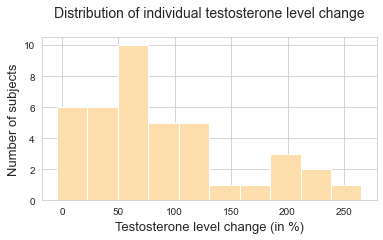

In [15]:
plt.hist(100*m_df[m_df['Test']==1].groupby('ID')['TPl_change'].mean(), color = 'navajowhite', density=False); 
plt.title('Distribution of individual testosterone level change', size = 14, pad=20);
plt.xlabel('Testosterone level change (in %)', size = 13);
plt.ylabel('Number of subjects', size = 13);
plt.savefig('imgs/'+ 'TestLevel.jpg',format='jpeg', dpi = 300, bbox_inches = 'tight')


## Exploratory data analysis

Real data, NO modelling at ALL

In [8]:
pd.DataFrame(win_money)

,0.9,0.7,0.5,0.3,0.1
A,2000,500,1000,1500,250
B,1500,250,500,500,50


On the right: real choices (mean value), splitted by the games, rel line  corresponds to 0.5
On the left, difference between risk and sure option, in money (Euro), equal choices with yellow line
For example: game 1, risk option greater by 300! Euro, BUT less then 0.60 in real


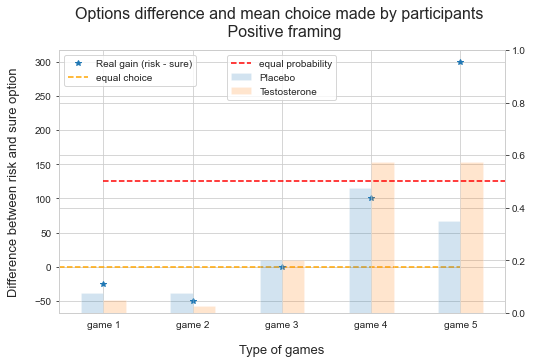

In [16]:
choiceP_T = m_df[(m_df['Win']==1)&((m_df['Test']==1))].groupby(['P'])['Strategy'].mean()
choiceP_Pl = m_df[(m_df['Win']==1)&((m_df['Test']==0))].groupby(['P'])['Strategy'].mean()

fig, ax1 = plt.subplots(figsize = (8,5))
fig.subplots_adjust(bottom=0.15)
p = list(win_money.keys())
lines = ax1.plot(p,[win_money[ps]['A']*ps - win_money[ps]['B']  for ps in p ],'*', label = 'Real gain (risk - sure)');
#ax1.legend(lines, ['Real gain (risk - sure)'] , loc='upper left')
ax1.set_xticks([0.1,0.3,0.5,0.7, 0.9])
ax1.hlines(0, 0,0.9, 'orange',linestyle='dashed',label=f"equal choice")
ax1.legend()
ax1.set_xlim(0,1)
ax1.set_xticklabels(['game 1','game 2','game 3','game 4', 'game 5'])
ax1.set_ylabel('Difference between risk and sure option', size= 13, labelpad=15);
ax1.set_xlabel('Type of games',size= 13, labelpad=15);
ax2 = ax1.twinx() 
plc = ax2.bar(choiceP_Pl.index, choiceP_Pl, width = -0.05, align='edge', alpha = 0.2, label = 'Placebo'); ax2.set_ylim((0,1));
horm = ax2.bar(choiceP_T.index, choiceP_T, width = 0.05, align='edge', alpha = 0.2, label = 'Testosterone'); ax2.set_ylim((0,1));
ax2.hlines(0.5, 0.1,1, 'red',linestyle='dashed',label=f"equal probability")
ax2.legend(loc = 'upper center');
plt.title(f'Options difference and mean choice made by participants \n Positive framing', size =16, pad = 14);
print('On the right: real choices (mean value), splitted by the games, rel line  corresponds to 0.5')
print('On the left, difference between risk and sure option, in money (Euro), equal choices with yellow line')
print('For example: game 1, risk option greater by 300! Euro, BUT less then 0.60 in real')
plt.savefig('imgs/'+ 'OptionsPos.jpg',format='jpeg', dpi = 300, bbox_inches = 'tight')


In [11]:
pd.DataFrame(loss_money)

,0.9,0.7,0.5,0.3,0.1
A,2400,600,1000,1800,1200
B,1200,200,500,600,400


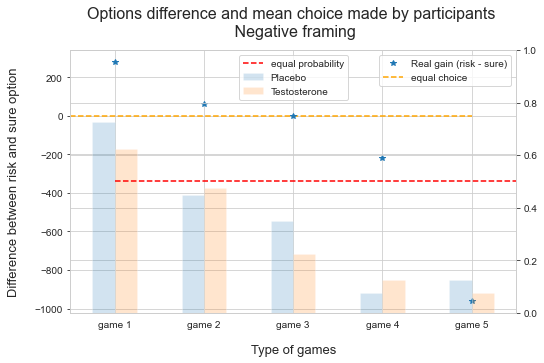

In [17]:
choiceP_T = m_df[(m_df['Win']==0)&((m_df['Test']==1))].groupby(['P'])['Strategy'].mean()
choiceP_Pl = m_df[(m_df['Win']==0)&((m_df['Test']==0))].groupby(['P'])['Strategy'].mean()

fig, ax1 = plt.subplots(figsize = (8,5))
fig.subplots_adjust(bottom=0.15)
p = list(loss_money.keys())
lines = ax1.plot(p,[-loss_money[ps]['A']*ps + loss_money[ps]['B']  for ps in p ],'*', label = 'Real gain (risk - sure)');
#ax1.legend(lines, ['Real gain (risk - sure)'] , loc='upper left')
ax1.set_xticks([0.1,0.3,0.5,0.7, 0.9])
ax1.set_xlim(0,1)
ax1.hlines(0, 0,0.9, 'orange',linestyle='dashed',label=f"equal choice")
ax1.legend()
ax1.set_xticklabels(['game 1','game 2','game 3','game 4', 'game 5'])
ax1.set_ylabel('Difference between risk and sure option', size= 13, labelpad=15);
ax1.set_xlabel('Type of games',size= 13, labelpad=15);
ax2 = ax1.twinx() 
plc = ax2.bar(choiceP_Pl.index, choiceP_Pl, width = -0.05, align='edge', alpha = 0.2, label = 'Placebo'); ax2.set_ylim((0,1));
horm = ax2.bar(choiceP_T.index, choiceP_T, width = 0.05, align='edge', alpha = 0.2, label = 'Testosterone'); ax2.set_ylim((0,1));
ax2.hlines(0.5, 0.1,1, 'red',linestyle='dashed',label=f"equal probability")
ax2.legend(loc = 'upper center');
plt.title(f'Options difference and mean choice made by participants \n Negative framing', size =16, pad = 14);
plt.savefig('imgs/'+ 'OptionsNeg.jpg',format='jpeg', dpi = 300, bbox_inches = 'tight')


## Utility function for gap estimation
From cpt theory: theano version for pyMC3 estimation


In [18]:
def weights_numpy(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = np.power(p,c)
    denom = np.power(np.power(p,c) + np.power(1-p,c),1/c)
    return numer/denom
def value_numpy(x,alpha):
    return np.sign(x)*np.abs(x)**alpha

In [19]:
def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1     
    """
    val  = tt.sgn(x)*tt.pow(tt.abs_(x),alpha)
    return val

def weights(p,c):
    """
    one-parameter weighting function used in Nilsson  
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5)     
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom

def gap(A, B, p, alpha, c):
    """
    Here for loss we also have positive values, so need to multiply gap value to -1 later
    
    compute subjective difference between two options: A (game), B (sure)
    @param A: float, positive, money, risk value
    @param B: float, positive, money, sure option
    @param alpha: float, expected to be less then 1  
    """
    val = value_f(A, alpha)*weights(p,c) - value_f(B, alpha)
    return val

## Models estimation

For all models:

$$y_i \sim Binomial(1, p_i)$$

For all models we used CPT parameters estimated on the data  from paper "Nilsson, H., Rieskamp, J. & Wagenmakers, E.-J. Hierarchical Bayesian parameter estimation for cumulative prospect theory. Journal of Mathematical Psychology 55, 84–93 (2011))" data available at https://osf.io/sbxm2/. All estimation can be found in "Rieskamp_replication.ipynb"


We used estimated from this data $\alpha_{Positive}  = 0.67$, $\alpha_{Negative}  = 0.97$ and $c_{Positive}  = 0.82$, $c_{Negative}  = 0.87$ as a prior distribution for subjective value estimation in our main model.


**Model 0. Baseline models, pooled (without testosterone condition)**

As a baseline we etimated two models: 
 - model 0.0: the one from prospect theory with aprior information from replication study, shift (A) and sensitivity (B) paramters don't depend on testosterone application
 
 
$$logit(p_i)  = A_{F} +B_{F}*gap(A,B,\alpha_{F},c_{F})$$
where F is framing type
$$A_{F} \sim Normal(\mu = 0, sd = 1, shape = 2)$$
$$B_{F} \sim Normal(\mu = 0.5, sd = 0.5, shape = 2)$$


 - model 0.1: the same as model 0.0, but with testosterone-related parameters
 
$$logit(p_i)  = A_{F} +B_{F}*gap(A,B,\alpha_{F},c_{F})$$

$$A_{F} = Ab_{F}+\delta\_A_{F}*TestosteroneChange$$
$$B_{F} = Bb_{F}+\delta\_B_{F}*TestosteroneChange$$


$$Ab_{F} \sim Normal(\mu = 0, sd = 1, shape = 2)$$
$$Bb_{F} \sim Normal(\mu = 0.5, sd = 0.5, shape = 2)$$

$$\delta\_A_{F} \sim Normal(\mu = 0, sd = 0.5, shape = 2)$$
$$\delta\_B_{F} \sim Normal(\mu = 0, sd = 0.5, shape = 2)$$

**Model 1. Hierarchical models with testosterone related parameters with and without covariates**


 - model without covariates
 The same as model 1, but A and B came from multivarite normal with estimated covariation from data
 
 $$logit(p_i)  = A_{ind,F} +B_{ind, F}*gap(A,B,\alpha_{F},c_{F})$$

 
 $$ A_{ind,F} \sim Normal(A_F+\delta\_A_F, \sigma_A, shape = (Ninds, 2))$$
 $$ B_{ind,F} \sim Normal(B_F+\delta\_B_F, \sigma_B, shape = (Ninds, 2))$$
 
 
  -  model with covariates
  
  We can (and maybe should) take into account the covariation between intercepts and slopes because we have repeated measures experiments what causes framing and shift and sensitivity parameters interdependencies 
  
  Formally $$[A,B] \sim MvNormal([A_F+\delta\_A_F, B_F+\delta\_B_F], \Sigma)$$

### Model evaluation functions

For model quality evaluation we used:
 - posterior predictive checks: how well model explain the same data from the model. In our case we used two scorings: roc_auc_score, and $R^2$ for regression between real choise and predictions at the group level 

 - WAIC (widely applicable information criterion) (the greater the better)

In [20]:
def get_idata(model, trace):
    with model:
        ppc = pm.sample_posterior_predictive(trace, var_names=["Strg","theta"], samples = 500)
        idata = az.from_pymc3(trace, posterior_predictive=ppc)
        game_labels = idata.constant_data.game_labels.values
        idata = idata.assign_coords({"GameId": ("obs_id", game_labels)})
    return idata  

In [21]:
def est_model(idata):

    real_choice = idata.constant_data.choice.groupby('GameId').mean().values
    choice = idata.posterior_predictive.mean(dim=("chain", "draw")).groupby('GameId').mean().Strg
    hdi_choice = az.hdi(idata.posterior_predictive.theta, hdi_prob = 0.95).groupby('GameId').mean().theta.values
    plt.plot(real_choice, choice, '*',[0,1],[0,1])
    plt.vlines(real_choice,hdi_choice[:,0], hdi_choice[:,1], colors='gray')
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(real_choice.reshape(-1,1), choice.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data (averaged by game): {regressor.score(real_choice.reshape(-1,1), choice.values.reshape(-1,1)):.2f}')
    score = roc_auc_score(idata.constant_data.choice, idata.posterior_predictive.mean(dim=("chain", "draw")).theta) 
    print(f'ROC_AUC score for real and predicted data: {score:.2f}')
    
def post_check(idata, varnames = ['shift','beta']):
    #idata = get_idata(model, trace)
    print('Log-likelihood:  ', az.waic(idata))
    print(az.summary(idata, var_names = varnames, kind = 'stats'))
    est_df = est_model(idata)
    az.plot_trace(idata, var_names = varnames);
    return est_df

In [22]:
m_df.head()

,ID,Strategy,Test,Win,P,A,B,Inds,GameId,TypeCode,TPl_change
0,PK01,1,1,1,0.9,2000,1500,24,19,1,0.764706
1,PK02,1,1,1,0.9,2000,1500,25,19,1,1.271429
2,PK03,1,1,1,0.9,2000,1500,26,19,1,0.872000
3,PK04,1,1,1,0.9,2000,1500,27,19,1,1.929293
4,PK05,0,1,1,0.9,2000,1500,28,19,1,1.634146


## Model 0. Pooled models
Pooled models without individual differences, with (model 0.1) and without (model 0.0) testosterone

### Model 0.0 Base pooled model without testosterone-related parameters

In [24]:
alphas = [0.96, 0.67]
cs = [0.87, 0.82]
chains = 4
n_samples = 5000
burnedin =1000

In [25]:
N = len(pd.unique(m_df.Inds))
coords = {"GameType": ["Loss","Gain"], "PId": list(m_df.Inds.unique()), "obs_id": np.arange(m_df.Inds.size)}

with pm.Model(coords=coords) as model_base_no_test:
         
    game_labels = pm.Data("game_labels", m_df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", m_df.Strategy.values, dims="obs_id")
    game_type = pm.Data("game_type", m_df.Win.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", m_df.Inds.values, dims = 'obs_id')
    
    alpha = tt.stack(alphas)
    c = tt.stack(cs)
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[game_type], c[game_type]) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    Gap = pm.Deterministic("Gap", Gap, dims = "obs_id")

    shift = pm.Normal('shift', 0, 1, dims = "GameType")
    beta = pm.Normal('beta', 0.5,0.5, dims = "GameType")
    
    A = shift[game_type]
    B = beta[game_type]
    theta_lin = A+B*Gap

    
    theta = pm.math.invlogit(theta_lin)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")

    strategy = pm.Binomial("Strg", 1, p=theta, observed=choice, dims="obs_id")
    
    trace_base_no_test = pm.sample(n_samples, tune=burnedin, target_accept=0.99, chains=chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 9900
Interrupted at 9,899 [4%]: Average Loss = 527.64
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, shift]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 47 seconds.


0, dim: obs_id, 800 =? 800


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable theta's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 800 =? 800
Log-likelihood:   Computed from 20000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -408.13    14.68
p_waic        4.12        -
           mean     sd  hdi_3%  hdi_97%
shift[0] -1.001  0.136  -1.260   -0.752
shift[1] -0.684  0.127  -0.930   -0.452
beta[0]   0.242  0.031   0.184    0.301
beta[1]   0.533  0.067   0.406    0.659
R^2 value for real and predicted data (averaged by game): 0.81
ROC_AUC score for real and predicted data: 0.77


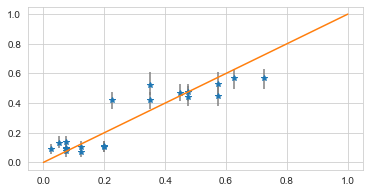

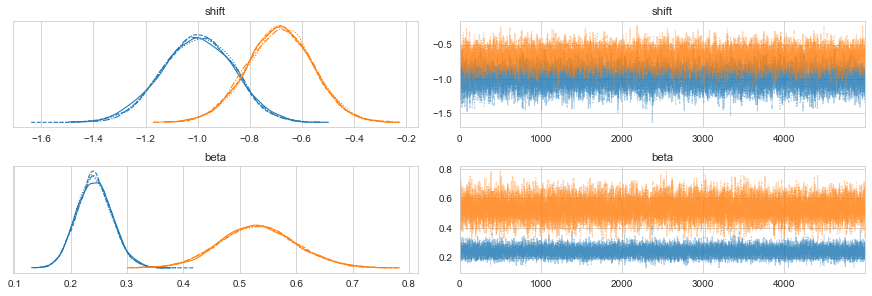

In [26]:
idata_base_no_test = get_idata(model_base_no_test, trace_base_no_test)
idata_base_no_test.to_netcdf('results/idata_base_no_test.nc')
post_check(idata_base_no_test, varnames = ['shift','beta'])

### Model 0.1 Base pooled model with testosterone-related parameters

In [27]:
N = len(pd.unique(m_df.Inds))
coords = {"GameType": ["Loss","Gain"], "PId": list(m_df.Inds.unique()), "obs_id": np.arange(m_df.Inds.size)}

with pm.Model(coords=coords) as model_base_test:
         
    game_labels = pm.Data("game_labels", m_df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", m_df.Strategy.values, dims="obs_id")
    game_type = pm.Data("game_type", m_df.Win.values, dims = 'obs_id')
    Tchange = pm.Data("Tchange",m_df.TPl_change.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", m_df.Inds.values, dims = 'obs_id')
    
    alpha = tt.stack(alphas)
    c = tt.stack(cs)
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[game_type], c[game_type]) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    Gap = pm.Deterministic("Gap", Gap, dims = "obs_id")

    shift = pm.Normal('shift', 0, 1, dims = "GameType")
    beta = pm.Normal('beta', 0.5,0.5, dims = "GameType")
    
    delta_shift = pm.Normal('delta_shift', 0, 0.5, dims = "GameType")
    delta_beta = pm.Normal('delta_beta', 0, 0.5, dims = "GameType")
    

    
    A = shift[game_type]+delta_shift[game_type]*Tchange
    B = beta[game_type]+delta_beta[game_type]*Tchange
    theta_lin = A+B*Gap

    
    theta = pm.math.invlogit(theta_lin)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")

    strategy = pm.Binomial("Strg", 1, p=theta, observed=choice, dims="obs_id")
    
    trace_base_test = pm.sample(n_samples, tune=burnedin, target_accept=0.99, chains=chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 18100
Interrupted at 18,099 [9%]: Average Loss = 504.21
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_beta, delta_shift, beta, shift]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 62 seconds.


0, dim: obs_id, 800 =? 800


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable theta's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 800 =? 800
Log-likelihood:   Computed from 20000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -407.73    14.93
p_waic        7.57        -

There has been a warning during the calculation. Please check the results.
                 mean     sd  hdi_3%  hdi_97%
shift[0]       -0.842  0.154  -1.127   -0.550
shift[1]       -0.741  0.148  -1.019   -0.464
beta[0]         0.233  0.037   0.164    0.302
beta[1]         0.461  0.079   0.315    0.607
delta_shift[0] -0.463  0.233  -0.901   -0.031
delta_shift[1]  0.102  0.192  -0.272    0.450
delta_beta[0]   0.043  0.058  -0.064    0.154
delta_beta[1]   0.192  0.113  -0.023    0.401
R^2 value for real and predicted data (averaged by game): 0.84
ROC_AUC score for real and predicted data: 0.77


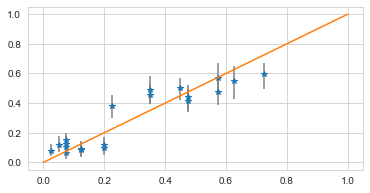

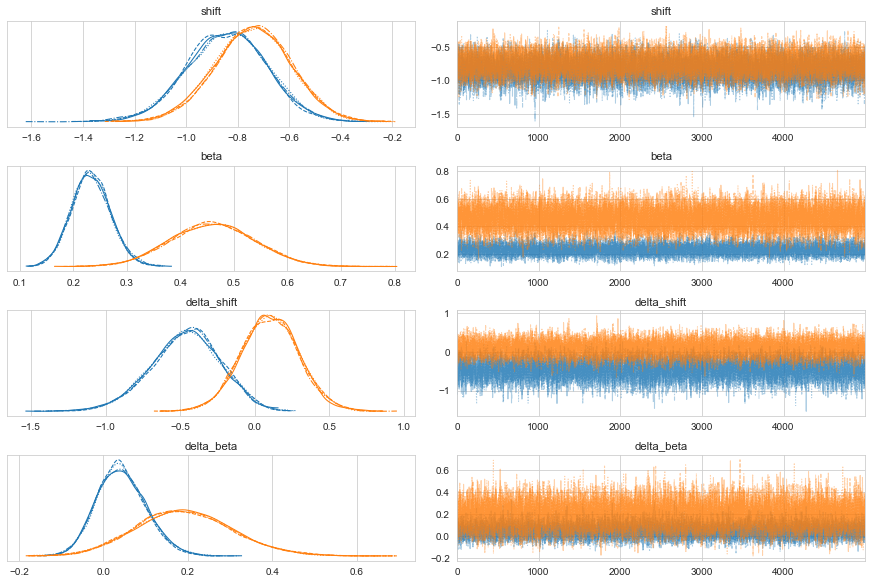

In [28]:
idata_base_test = get_idata(model_base_test, trace_base_test)
idata_base_test.to_netcdf('results/idata_base_test.nc')
post_check(idata_base_test, varnames = ['shift','beta', 'delta_shift', 'delta_beta'])

## Model 1. Hierarhical with individual differences

In [29]:
N = len(pd.unique(m_df.Inds))
coords = {"GameType": ["Loss","Gain"], "PId": list(m_df.Inds.unique()), "obs_id": np.arange(m_df.Inds.size)}

with pm.Model(coords=coords) as model_inds:
         
    game_labels = pm.Data("game_labels", m_df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", m_df.Strategy.values, dims="obs_id")
    game_type = pm.Data("game_type", m_df.Win.values, dims = 'obs_id')
    Tchange = pm.Data("Tchange",m_df.TPl_change.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", m_df.Inds.values, dims = 'obs_id')
    
    alpha = tt.stack(alphas)
    c = tt.stack(cs)
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[game_type], c[game_type]) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    Gap = pm.Deterministic("Gap", Gap, dims = "obs_id")

    shift = pm.Normal('shift', 0, 1, dims = "GameType")
    beta = pm.Normal('beta', 0.5,0.5, dims = "GameType")
    
    delta_shift = pm.Normal('delta_shift', 0, 0.5, dims = "GameType")
    delta_beta = pm.Normal('delta_beta', 0, 0.5, dims = "GameType")
    
    
    sigma_shift = pm.Exponential("sigma_shift", 1.0)
    sigma_beta = pm.Exponential("sigma_beta", 0.5)

 
    z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sd=1.0, dims=("PId", "GameType"))
    z_beta_ind = pm.Normal("z_beta_ind", mu=0.0, sd=1.0, dims=("PId", "GameType"))

    shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims=("PId", "GameType"))   
    beta_ind = pm.Deterministic("beta_ind", z_beta_ind * sigma_beta, dims=("PId", "GameType"))   
    
    
    A = shift_ind[pid,game_type] +shift[game_type]+delta_shift[game_type]*Tchange
    B = beta_ind[pid,game_type]+beta[game_type]+delta_beta[game_type]*Tchange
    
    

    theta_lin = A+B*Gap

    
    theta = pm.math.invlogit(theta_lin)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")

    strategy = pm.Binomial("Strg", 1, p=theta, observed=choice, dims="obs_id")
    
    trace_inds = pm.sample(n_samples, tune=burnedin, target_accept=0.99, chains=chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 16600
Interrupted at 16,599 [8%]: Average Loss = 529.44
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_beta_ind, z_shift_ind, sigma_beta, sigma_shift, delta_beta, delta_shift, beta, shift]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 214 seconds.


0, dim: obs_id, 800 =? 800


The number of effective samples is smaller than 25% for some parameters.


Log-likelihood:   Computed from 20000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -319.30    15.40
p_waic       79.22        -

There has been a warning during the calculation. Please check the results.
                 mean     sd  hdi_3%  hdi_97%
shift[0]       -1.678  0.378  -2.392   -0.970
shift[1]       -1.083  0.310  -1.673   -0.520
beta[0]         0.526  0.107   0.332    0.727
beta[1]         0.674  0.126   0.443    0.918
delta_shift[0] -0.489  0.311  -1.092    0.072
delta_shift[1]  0.246  0.240  -0.188    0.712
delta_beta[0]  -0.018  0.085  -0.173    0.147
delta_beta[1]   0.282  0.138   0.035    0.553
R^2 value for real and predicted data (averaged by game): 0.86
ROC_AUC score for real and predicted data: 0.94


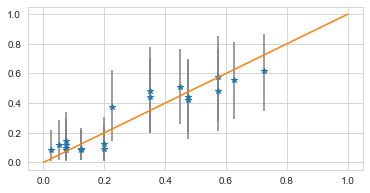

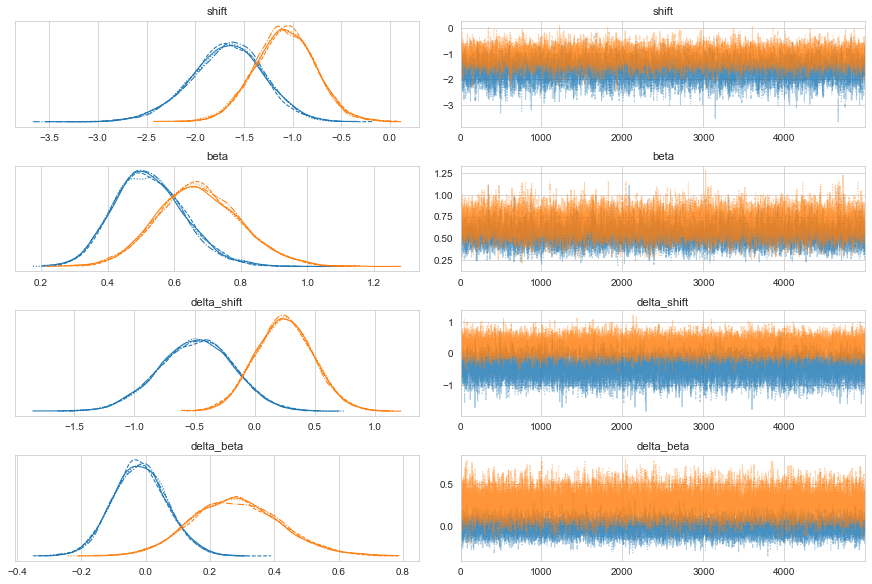

In [26]:
PRECOMPUTED = True
if PRECOMPUTED:
    idata_inds  = az.from_netcdf('results/idata_inds.nc')
else:    
    idata_inds = get_idata(model_inds, trace_inds)
    idata_inds.to_netcdf('results/idata_inds.nc')
post_check(idata_inds, varnames = ['shift','beta', 'delta_shift', 'delta_beta'])

## Model 1.1 with covariates between all coeffs

In [31]:
chains = 4
N = len(pd.unique(m_df.Inds))
coords = {"GameType": ["Loss","Gain"], "PId": list(m_df.Inds.unique()), 
          "obs_id": np.arange(m_df.Inds.size), "params": ["shift_N", "beta_N", "shift_P", "beta_P"]}

with pm.Model(coords=coords) as model_inds_cov:
         
    game_labels = pm.Data("game_labels", m_df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", m_df.Strategy.values, dims="obs_id")
    game_type = pm.Data("game_type", m_df.Win.values, dims = 'obs_id')
    Tchange = pm.Data("Tchange",m_df.TPl_change.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", m_df.Inds.values, dims = 'obs_id')
    
    alpha = tt.stack(alphas)
    c = tt.stack(cs)
    Gap = gap(m_df.A, m_df.B, m_df.P, alpha[game_type], c[game_type]) 
    Gap = tt.sgn(Gap)*tt.log(1+tt.abs_(Gap))
    Gap = pm.Deterministic("Gap", Gap, dims = "obs_id")

    shift = pm.Normal('shift', 0, 1, dims = "GameType")
    beta = pm.Normal('beta', 0.5,0.5, dims = "GameType")
    
    delta_shift = pm.Normal('delta_shift', 0, 0.5, dims = "GameType")
    delta_beta = pm.Normal('delta_beta', 0, 0.5, dims = "GameType")
    
    chol_inds, _, _ = pm.LKJCholeskyCov(
        "chol_inds", n=4, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    z_inds = pm.Normal("z_inds", mu=0, sd=1, dims = ("params", "PId")) 

    shift_beta_inds = pm.Deterministic("ab_inds", pm.math.dot(chol_inds, z_inds), dims = ("params", "PId"))
    

    
    A = shift_beta_inds[2*game_type,pid] +shift[game_type]+delta_shift[game_type]*Tchange
    B = shift_beta_inds[2*game_type+1,pid]+beta[game_type]+delta_beta[game_type]*Tchange
    
    

    theta_lin = A+B*Gap

    
    theta = pm.math.invlogit(theta_lin)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")

    strategy = pm.Binomial("Strg", 1, p=theta, observed=choice, dims="obs_id")
    
    trace_inds_cov = pm.sample(n_samples, tune=burnedin, target_accept=0.99, chains=chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 17900
Interrupted at 17,899 [8%]: Average Loss = 533.04
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_inds, chol_inds, delta_beta, delta_shift, beta, shift]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2896 seconds.


0, dim: obs_id, 800 =? 800


The number of effective samples is smaller than 10% for some parameters.


Log-likelihood:   Computed from 20000 by 800 log-likelihood matrix

          Estimate       SE
elpd_waic  -313.77    15.42
p_waic       72.85        -

There has been a warning during the calculation. Please check the results.
                 mean     sd  hdi_3%  hdi_97%
shift[0]       -2.103  0.490  -3.023   -1.207
shift[1]       -0.984  0.312  -1.590   -0.414
beta[0]         0.632  0.141   0.374    0.895
beta[1]         0.634  0.121   0.408    0.858
delta_shift[0] -0.430  0.323  -1.025    0.187
delta_shift[1]  0.242  0.239  -0.227    0.666
delta_beta[0]  -0.029  0.090  -0.193    0.144
delta_beta[1]   0.269  0.136   0.011    0.520
R^2 value for real and predicted data (averaged by game): 0.88
ROC_AUC score for real and predicted data: 0.94


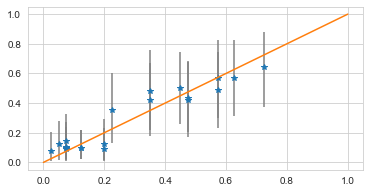

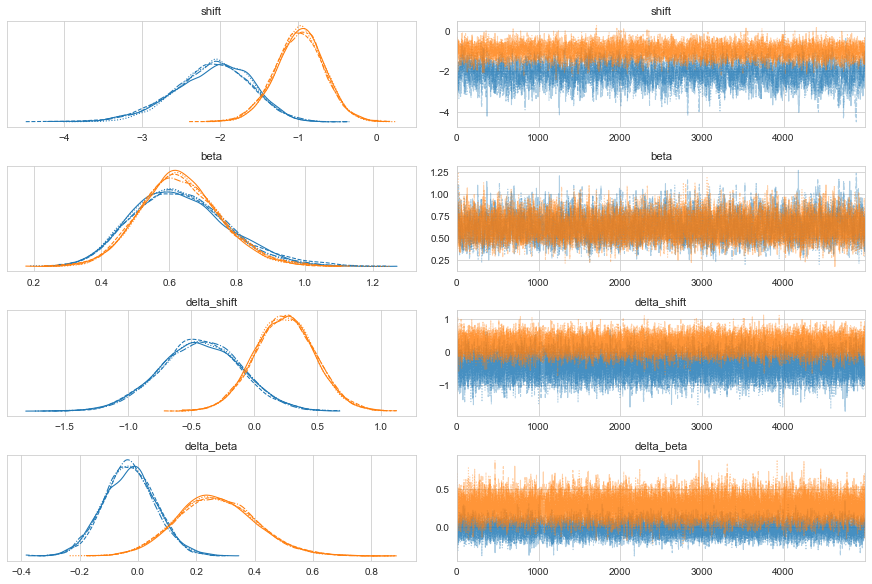

In [27]:
PRECOMPUTED = True
if PRECOMPUTED:
    idata_inds_cov  = az.from_netcdf('results/idata_inds_cov.nc')

else:    
    idata_inds_cov = get_idata(model_inds_cov, trace_inds_cov)
    idata_inds_cov.to_netcdf('results/idata_inds_cov.nc')
post_check(idata_inds_cov, varnames = ['shift','beta', 'delta_shift', 'delta_beta'])

In [33]:
df_corr =az.summary(trace_inds_cov, var_names = ["chol_inds_corr"])["mean"]

0, dim: obs_id, 800 =? 800


/Users/irinaknyazeva/opt/anaconda3/envs/pymc/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


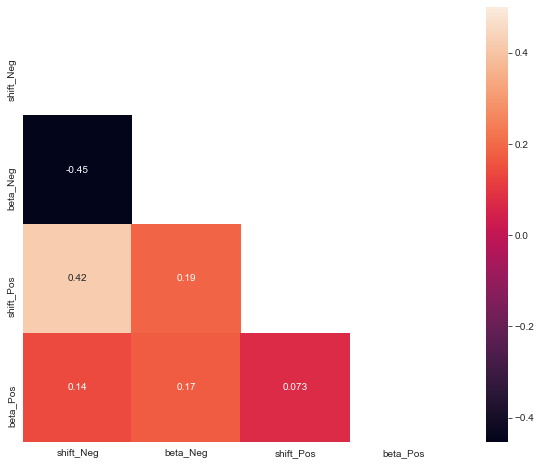

In [34]:
treatment = ['shift_Neg', 'beta_Neg','shift_Pos', 'beta_Pos']
corr_mat = np.ones((4,4))
k = 0
for i in range(4):
    for j in range(4):
        corr_mat[i,j] = df_corr.values[k]
        k=k+1
f,ax = plt.subplots(1,1, figsize=(10, 8))
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr_mat, mask=mask, vmax=0.5, annot = True, square=True, xticklabels=treatment, yticklabels=treatment)

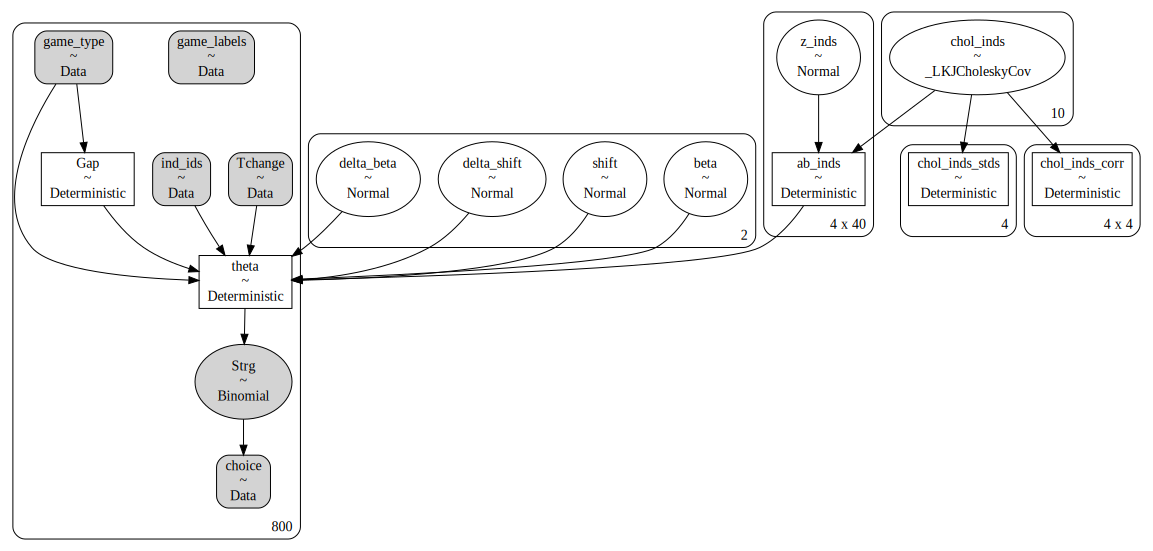

In [35]:
pm.model_to_graphviz(model_inds_cov)

### So what? 

Nothing: it was fun, but coefficients with and without covariates almost the same, especially testosterone-related, along with other metrics. But, it sounds better, so we can use them.

In [29]:
idata_inds_cov

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

## Model interpretation

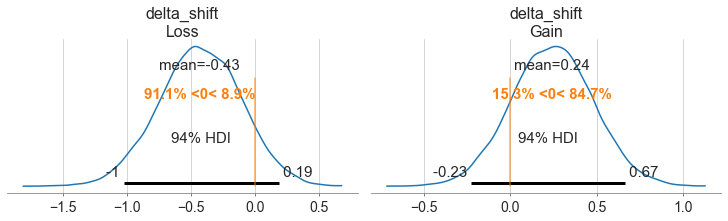

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

az.plot_posterior(idata_inds_cov, var_names=['delta_shift'], ref_val=0, ax=ax);


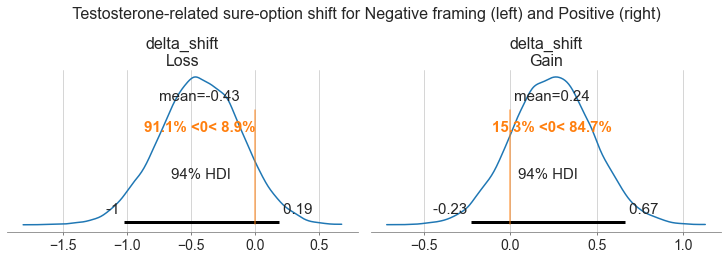

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
az.plot_posterior(idata_inds_cov, var_names=['delta_shift'], ref_val=0, ax=ax);
fig.suptitle(f" Testosterone-related sure-option shift for Negative framing (left) and Positive (right)", fontsize=16);

In [43]:
def plot_deltas(idata):

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
    az.plot_posterior(idata, var_names=['delta_shift'], ref_val=0, ax=ax);
    fig.suptitle(f" Testosterone-related sure-option shift for Negative framing (left) and Positive (right)", fontsize=16);
    plt.savefig('imgs/'+ 'DeltasShift.jpg',format='jpeg', bbox_inches = 'tight')

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
    az.plot_posterior(idata, var_names=['delta_beta'], ref_val=0, ax = ax)
    fig.suptitle(f" Testosterone-related sensitivity to gap for Negative framing (left) and Positive (right)", fontsize=16);
    plt.savefig('imgs/'+ 'DeltasGap.jpg',format='jpeg', bbox_inches = 'tight')



## Testosterone-related parameters 

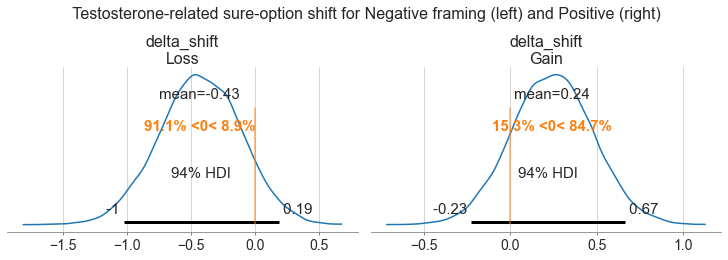

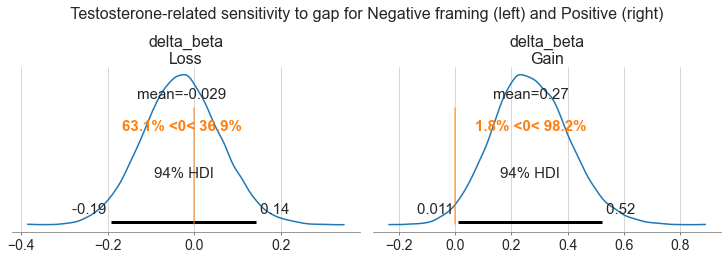

In [46]:
plot_deltas(idata_inds_cov)

In [65]:
idata_inds_cov.posterior['shift'].mean(["chain", "draw"]).values

array([-2.10322969, -0.98442543])

In [63]:
az.hdi(idata_inds_cov, var_names= ['shift'], hdi_prob = 0.5)['shift'].values

array([[-2.32514924, -1.67585025],
       [-1.15009187, -0.74138749]])

## Effects analysis

In [85]:
def get_params_bounds(idata, hdi_prob = 0.5):
    
    params = {}
    params['a_mu'] = idata.posterior['shift'].mean(["chain", "draw"]).values
    params['a_bounds'] = az.hdi(idata, var_names= ['shift'], hdi_prob = hdi_prob)['shift'].values
    params['beta_mu'] = idata.posterior['beta'].mean(["chain", "draw"]).values
    params['beta_bounds'] = az.hdi(idata, var_names= ['beta'], hdi_prob = hdi_prob)['beta'].values
    params['delta_a_mu'] = idata.posterior['delta_shift'].mean(["chain", "draw"]).values
    params['delta_a_bounds'] = az.hdi(idata, var_names= ['delta_shift'], hdi_prob = hdi_prob)['delta_shift'].values
    params['delta_b_mu'] = idata.posterior['delta_beta'].mean(["chain", "draw"]).values
    params['delta_b_bounds'] = az.hdi(idata, var_names= ['delta_beta'], hdi_prob = hdi_prob)['delta_beta'].values

    return params
    


def risk_sens_testn(idata, tchange = np.linspace(0,3,30), hdi_prob = 0.5, gaps = [1,15,150]):
    gaps = list(np.sign(gaps)*np.log1p(np.abs(gaps)))
    plt.figure(figsize = (15,6))

    #ind = 0 (Negative),1 (Positive)
    params = get_params_bounds(idata, hdi_prob = hdi_prob)
    
    def theta_errs(ind, gap):
        theta = invlogit(params['a_mu'][ind]+params['delta_a_mu'][ind]*tchange+(params['beta_mu'][ind]+params['delta_b_mu'][ind]*tchange)*gap)
        theta_lb = invlogit(params['a_bounds'][ind,0]+params['delta_a_bounds'][ind,0]*tchange+(params['delta_b_bounds'][ind,0]*tchange+params['beta_bounds'][ind,0])*gap)
        theta_ub = invlogit(params['a_bounds'][ind,1]+params['delta_a_bounds'][ind,1]*tchange+(params['delta_b_bounds'][ind,1]*tchange+params['beta_bounds'][ind,1])*gap)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potenial gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(gaps)))

    plt.subplot(1,2,1); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,gap)
        plt.plot(tchange, theta_W, color=c, label = f'Gain: {np.expm1(gap):.0f}'); plt.ylim(0,1); plt.legend()
        plt.fill_between(tchange, theta_W_lb,theta_W_ub, color = c, alpha=0.1)
        #plt.vlines(tchange, theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option', size = 13)
    plt.xlabel('Change in testosterone level compared to placebo states',  size = 13)
    plt.title('Positive framing', size = 16)
    plt.ylim(-0.1,1.1)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for gap, c in zip(gaps,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,gap)
        plt.plot(tchange, theta_W, label = f'Loss: {np.sign(gap)*np.expm1(np.abs(gap)):.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.fill_between(tchange, theta_W_lb,theta_W_ub, color = c, alpha=0.1)

        #plt.vlines(tchange, theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option', size = 13)
    plt.xlabel('Change in testosterone level compared to placebo states', size = 13)
    plt.title('Negative framing', size = 16)
    plt.ylim(-0.1,1.1)
    plt.savefig('imgs/'+ 'RiskSensTest.jpg',format='jpeg', dpi = 300, bbox_inches = 'tight')

    plt.legend()
    return theta_W, theta_W_lb, theta_W_ub

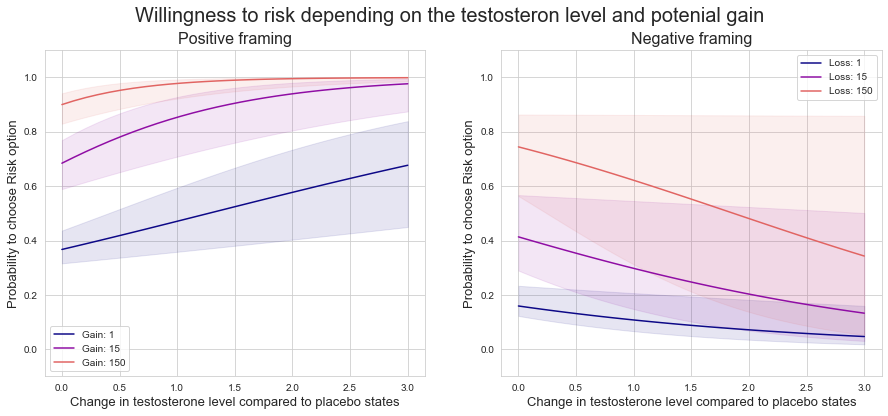

In [87]:
theta_W, theta_W_lb, theta_W_ub = risk_sens_testn(idata_inds_cov, gaps = [1,15,150], hdi_prob = 0.5)

In [88]:
def gap_sens_testn(idata, gaps = np.linspace(0,5,50), hdi_prob = 0.5, testn = [0,0.6,2]):
    plt.figure(figsize = (15,6))

    params = get_params_bounds(idata, hdi_prob = hdi_prob)

    def theta_errs(ind, test):
        theta = invlogit(params['a_mu'][ind]+params['delta_a_mu'][ind]*test+(params['beta_mu'][ind]+params['delta_b_mu'][ind]*test)*gaps)
        theta_lb = invlogit(params['a_bounds'][ind,0]+params['delta_a_bounds'][ind,0]*test+(params['delta_b_bounds'][ind,0]*test+params['beta_bounds'][ind,0])*gaps)
        theta_ub = invlogit(params['a_bounds'][ind,1]+params['delta_a_bounds'][ind,1]*test+(params['delta_b_bounds'][ind,1]*test+params['beta_bounds'][ind,1])*gaps)
        return theta, theta_lb, theta_ub

    plt.suptitle(f'Willingness to risk depending on the testosteron level and potential gain', fontsize = 20)

    colors=cm.plasma(np.linspace(0,0.6,len(testn)))

    plt.subplot(1,2,1); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(1,test)
        plt.plot(np.expm1(gaps), theta_W, color=c, label = f'ChangeTest: {100*test:.0f}'); plt.ylim(0,1); plt.legend()
        plt.fill_between(np.expm1(gaps), theta_W_lb,theta_W_ub, color = c, alpha=0.1)
        #plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors = c, alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option',  size = 13)
    plt.xlabel('Value function for game-sure option differences', size = 13)
    plt.title('Positive framing', size = 16)
    plt.legend()
    
    
    plt.subplot(1,2,2); 
    for test, c in zip(testn,colors):
        theta_W, theta_W_lb, theta_W_ub = theta_errs(0,test)
        plt.plot(np.expm1(gaps), theta_W, label = f'ChangeTest: {100*test:.0f}', color=c); plt.ylim(0,1); plt.legend()
        plt.fill_between(np.expm1(gaps), theta_W_lb,theta_W_ub, color = c, alpha=0.1)

        #plt.vlines(np.expm1(gaps), theta_W_lb,theta_W_ub, colors=c,alpha=0.4)
    
    plt.ylabel('Probability to choose Risk option',  size = 13)
    plt.xlabel('Value function for game-sure option differences',  size = 13)
    plt.title('Negative framing', size = 16)
    plt.savefig('imgs/'+ 'RiskSensGap.jpg',format='jpeg', dpi = 300, bbox_inches = 'tight')

    plt.legend()


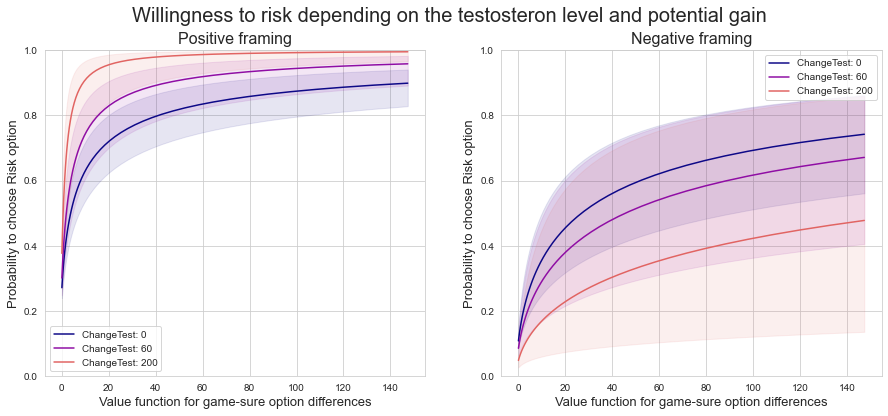

In [89]:
gap_sens_testn(idata_inds_cov, hdi_prob=0.5)